# 학습 전 세팅

## 필요한 라이브러리 설치하기

In [1]:
!pip install PyTDC
!pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 데이터 불러오기

**CRISPR Repair Outcome Prediction Task**

[TDC - CRISPROutcome](https://tdcommons.ai/single_pred_tasks/CRISPROutcome/)


In [2]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('Leenay')

In [3]:
from tdc.single_pred import CRISPROutcome
data = CRISPROutcome(name = 'Leenay', label_name = label_list[0])
split = data.get_split()

Found local copy...
Loading...
Done!


In [4]:
# 나누어진 데이터 확인
split.keys()

dict_keys(['train', 'valid', 'test'])

In [5]:
# Train data
split['train']

,GuideSeq_ID,GuideSeq,Y
0,GuideSeq 1,CTGCAGGGCTAGTTTCCTATAGG,0.069572
1,GuideSeq 2,GAGATGCGGACCACCCAGCTGGG,0.287647
2,GuideSeq 3,GCAAACGGAAGTGCAATTGTCGG,0.137004
3,GuideSeq 4,GTCATCGCTGAGTTGAGGAAGGG,0.093889
4,GuideSeq 5,ATATGATTATCCCTGCACAAGGG,0.526525
...,...,...,...
1060,GuideSeq 1517,ATGCCCGACCAAAGACAACCAGG,0.093236
1061,GuideSeq 1518,CACGCTGTCATCCACCAGGTAGG,0.069054
1062,GuideSeq 1519,GGGCTCCAGAGTCTGATACAGGG,0.421439
1063,GuideSeq 1520,AAAGACTTCGGTCCTCTAGTAGG,0.206277


In [6]:
split['train']['GuideSeq'].apply(len)

0       23
1       23
2       23
3       23
4       23
        ..
1060    23
1061    23
1062    23
1063    23
1064    23
Name: GuideSeq, Length: 1065, dtype: int64

In [7]:
# Train data
split['valid']

,GuideSeq_ID,GuideSeq,Y
0,GuideSeq 841,CCTTGTGAATCTCCTCACGGAGG,0.394674
1,GuideSeq 101,CGCTTTACCTGCGACCAGGTAGG,0.072320
2,GuideSeq 235,CATTCTCCAAGTGACAAGGTAGG,0.049883
3,GuideSeq 162,CTTGGTCATGCCTTCCCGGTAGG,0.206285
4,GuideSeq 421,AAAGTACTCGAAGTATTCTTGGG,0.061223
...,...,...,...
147,GuideSeq 986,TTTACTCTCAGAAACCTACCTGG,0.113981
148,GuideSeq 744,GATGAGGCCTGTAGAGACGTAGG,0.092636
149,GuideSeq 1447,TTGCCTACTCACTTCCTTGGAGG,0.211790
150,GuideSeq 521,CTATCCCTCACGATGGAAGTAGG,0.089396


In [8]:
# Train data
split['test']

,GuideSeq_ID,GuideSeq,Y
0,GuideSeq 567,TGTGCAATATCTGGTACTAAGGG,0.176660
1,GuideSeq 1102,TGTCTGGCCAGCAGAATACAGGG,0.300800
2,GuideSeq 1474,ACTGAGAGTGGATCCGAAAGTGG,0.153200
3,GuideSeq 1178,GTTCTGCACCAGCACATTCACGG,0.192665
4,GuideSeq 1010,ACTGGATGGACAAGACTGGTGGG,0.229076
...,...,...,...
299,GuideSeq 1413,TATGAAGCATGGGTCTGAGTCGG,0.108374
300,GuideSeq 721,ATGTTGGACAGCTGCCCGGTGGG,0.203401
301,GuideSeq 234,GACCAGGGCCACATCTTTAAAGG,0.143219
302,GuideSeq 894,AGTAGACTGACCTGGTAGGAGGG,0.200965


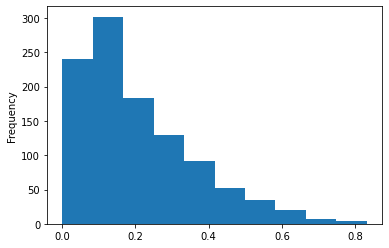

In [9]:
split['train']['Y'].plot.hist()

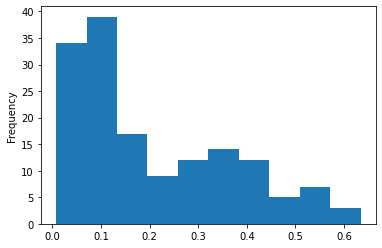

In [10]:
split['valid']['Y'].plot.hist()

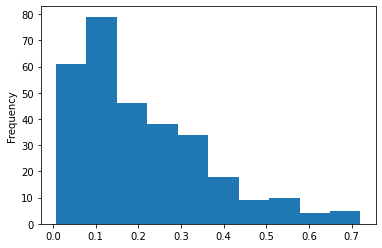

In [11]:
split['test']['Y'].plot.hist()

## 데이터 전처리 및 torch dataloader 만들기

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

class SeqProcessor:
    def __init__(self, char, max_seq):
        # One-hot encoding에 사용할 character 정의
        self.char = char
        #  ㅒne-hot 인코더 fitting
        self.enc_dna = OneHotEncoder().fit(np.array(self.char).reshape(-1, 1))
        # Sequence 최대 길이
        self.max_seq = max_seq

    def trans_dna(self, x: str) -> list:
        """Protein sequence 데이터 전처리
        모든 sequence를 같은 크기의 리스트로 만들고
        사전 정의된 character에 해당 되지 않는 값은 ?로 변환한다.

        Args:
            x: A sequence
        """
        temp = list(x.upper()) # 대문자로 바꾸기
        temp = [i if i in self.char else '?' for i in temp] # 

        if len(temp) < self.max_seq:
            # MAX_SEQ_DNA 보다 작으면 뒷부분을 ?로 채워서 MAX_SEQ_DRUG 길이의 리스트로 만들기
            temp = temp + ['?'] * (self.max_seq-len(temp))
        else:
            # MAX_SEQ_DNA 보다 크면 앞에서부터 MAX_SEQ_DRUG 만큼 슬라이싱
            temp = temp [:self.max_seq]

        return temp

    def dna_2_embed(self, x: list) -> np.ndarray:
        return self.enc_dna.transform(np.array(x).reshape(-1,1)).toarray().T


In [14]:
import torch
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [15]:
# Custom dataset 만들기 

class data_process_loader(Dataset):
    def __init__(self, df: pd.DataFrame, sp: SeqProcessor):
        self.sp = sp
        self.df = df

    def __len__(self):
        return self.df.shape[0] 

    def __getitem__(self, index):
      
        # Target 데이터
        v_s = self.df.iloc[index]['GuideSeq'] 
        v_s = self.sp.trans_dna(v_s)
        v_s = self.sp.dna_2_embed(v_s) # Target One-hot 인코딩 [26,100]

        # Binding affinity (label)
        y = self.df.iloc[index]['Y'] 

        return v_s, y


In [16]:
# defince processor for dna sequence
dna_char=['?', 'A', 'T', 'G', 'C']
max_seq=23

sp = SeqProcessor(dna_char, max_seq)

In [17]:
train_dataset = data_process_loader(split["train"], sp)
valid_dataset = data_process_loader(split["valid"], sp)
test_dataset = data_process_loader(split["test"], sp)

In [18]:
# DataLoader을 위한 hyperparameter 설정

params = {'batch_size': 64,
        'shuffle': True,
        'num_workers': 1,
        'drop_last': False}

training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(valid_dataset, **params)
test_generator = DataLoader(test_dataset, **params)

In [19]:
# Dataloader 확인해보기 

for (v_s, y) in training_generator:
    print(v_s.shape)
    print(y)
    break

torch.Size([64, 5, 23])
tensor([0.2423, 0.1852, 0.1444, 0.0410, 0.0971, 0.1152, 0.1913, 0.0850, 0.0395,
        0.0182, 0.3635, 0.3035, 0.1121, 0.2075, 0.1239, 0.4062, 0.1920, 0.1637,
        0.2571, 0.1717, 0.3352, 0.1756, 0.0720, 0.0700, 0.0187, 0.1319, 0.3004,
        0.0206, 0.0777, 0.3624, 0.1258, 0.1105, 0.7208, 0.1033, 0.2153, 0.5612,
        0.3766, 0.1410, 0.1000, 0.3386, 0.3089, 0.1358, 0.0830, 0.0805, 0.3391,
        0.4121, 0.1353, 0.2600, 0.4699, 0.5311, 0.4214, 0.3707, 0.1701, 0.3309,
        0.1397, 0.0831, 0.1664, 0.1092, 0.2974, 0.3331, 0.0781, 0.1556, 0.1355,
        0.1441], dtype=torch.float64)


In [20]:
# Dataloader 확인해보기 

for (v_s, y) in valid_generator:
    print(v_s.shape)
    print(y)
    break

torch.Size([64, 5, 23])
tensor([0.1490, 0.5004, 0.1377, 0.2934, 0.2021, 0.5262, 0.5707, 0.1327, 0.0236,
        0.1213, 0.0631, 0.1296, 0.3088, 0.2721, 0.1273, 0.1805, 0.1706, 0.1120,
        0.2976, 0.1026, 0.0695, 0.1185, 0.3210, 0.1058, 0.2350, 0.0862, 0.4994,
        0.0699, 0.1222, 0.3341, 0.0810, 0.0723, 0.4078, 0.0956, 0.0950, 0.4588,
        0.1412, 0.0733, 0.3917, 0.3805, 0.5307, 0.0388, 0.1782, 0.0206, 0.3377,
        0.0361, 0.0417, 0.0843, 0.1345, 0.3644, 0.4433, 0.3938, 0.2985, 0.1223,
        0.0894, 0.0930, 0.0148, 0.0206, 0.1565, 0.5394, 0.1542, 0.0705, 0.2433,
        0.0656], dtype=torch.float64)


In [21]:
# Dataloader 확인해보기 

for (v_s, y) in test_generator:
    print(v_s.shape)
    print(y)
    break

torch.Size([64, 5, 23])
tensor([0.0997, 0.3959, 0.0869, 0.1062, 0.5363, 0.1357, 0.1356, 0.2381, 0.2864,
        0.4818, 0.3891, 0.6468, 0.0658, 0.1312, 0.1086, 0.0540, 0.0457, 0.1185,
        0.2310, 0.2544, 0.1384, 0.0987, 0.3924, 0.3471, 0.2970, 0.2010, 0.3750,
        0.3498, 0.1011, 0.2034, 0.3115, 0.4253, 0.1006, 0.2003, 0.4888, 0.1246,
        0.5179, 0.1120, 0.3918, 0.0520, 0.1084, 0.0494, 0.4338, 0.3162, 0.1004,
        0.1633, 0.1341, 0.1008, 0.2999, 0.1940, 0.1418, 0.0822, 0.0853, 0.1075,
        0.0769, 0.0849, 0.2924, 0.3538, 0.1189, 0.2407, 0.5521, 0.5326, 0.3327,
        0.1504], dtype=torch.float64)


## 학습에 사용할 모델 만들기

In [22]:
# 모델 설정 값

config = {
    # dna embedding layer 설정
    "cnn_filters" : [32,64,96],
    "cnn_kernels" : [3,3,3],
    "hidden_dim" : 256,
    "rnn_hid_dim" : 64,
    "rnn_n_layers" : 2,
    "rnn_bidirectional" : True,
    "rnn_Use_GRU_LSTM" : 'GRU',

    # Classfier 설정
    "cls_hidden_dims" : [1024, 512]
    }

In [23]:
class CNN_RNN(nn.Sequential):

    def __init__(self, **config):
        super(CNN_RNN, self).__init__()
        self.config = config
        """
        CNN 구현 
        """
        # 레이어 별 CNN 필터 개수 
        in_ch = [5] + config['cnn_filters']
        self.in_ch = in_ch[-1] # 마지막 convolution 층 필터 개수

        # 레이어 별 CNN kernel 사이즈
        kernels = config['cnn_kernels']

        # 전체 CNN Layer 개수
        layer_size = len(config['cnn_filters'])

        self.conv = nn.ModuleList([nn.Conv1d(in_channels = in_ch[i], # input 채널 수
                                                out_channels = in_ch[i+1], # output 채널 수
                                                kernel_size = kernels[i]) for i in range(layer_size)]) # kernel 사이즈
        self.conv = self.conv.double()

        # 마지막 층 사이즈 구하기
        n_size_d = self._get_conv_output((5, 23)) # auto get the seq_len of CNN output

        """
        RNN 구현 (LSTM / GRU)
        """
        if config['rnn_Use_GRU_LSTM'] == 'LSTM':
            self.rnn = nn.LSTM(input_size = in_ch[-1], # input feature 사이즈 (convolution 이 후 채널 개수)
                            hidden_size = config['rnn_hid_dim'], # hidden feature 사이즈
                            num_layers = config['rnn_n_layers'], # recurrent layer 개수
                            batch_first = True, # If True, (batch, seq, feature) Else, (seq, batch, feature)
                            bidirectional = config['rnn_bidirectional']) # If True, Bidirectional LSTM
        
        elif config['rnn_Use_GRU_LSTM'] == 'GRU':
            self.rnn = nn.GRU(input_size = in_ch[-1], # input feature 사이즈 (convolution 이 후 채널 개수)
                            hidden_size = config['rnn_hid_dim'], # hidden feature 사이즈
                            num_layers = config['rnn_n_layers'], # recurrent layer 개수
                            batch_first = True, # If True, (batch, seq, feature) Else, (seq, batch, feature
                            bidirectional = config['rnn_bidirectional']) # If True, Bidirectional LSTM
        else:
            raise AttributeError('Please use LSTM or GRU.')

        direction = 2 if config['rnn_bidirectional'] else 1
        self.rnn = self.rnn.double()

        # 마지막 drug 임베딩 층
        self.fc1 = nn.Linear(config['rnn_hid_dim'] * direction * n_size_d, config['hidden_dim'])

    def _get_conv_output(self, shape):
        
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input.double())
        n_size = output_feat.data.view(bs, self.in_ch, -1).size(2)
        return n_size

    def _forward_features(self, x):
        for l in self.conv:
            x = F.relu(l(x))
        return x

    def forward(self, v):
        v = self._forward_features(v.double())
  
        batch_size = v.size(0)
        v = v.view(batch_size, v.size(2), -1) 

        if self.config['rnn_Use_GRU_LSTM'] == 'LSTM':
            direction = 2 if self.config['rnn_bidirectional'] else 1
            h0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize hidden state
            c0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device) # Initialize cell state
            v, (hn, cn) = self.rnn(v.double(), (h0.double(), c0.double()))
        else:
            # GRU
            direction = 2 if self.config['rnn_bidirectional'] else 1
            h0 = torch.randn(self.config['rnn_n_layers'] * direction, batch_size, self.config['rnn_hid_dim']).to(device)
            v, hn = self.rnn(v.double(), h0.double())

        v = torch.flatten(v, 1)
        v = self.fc1(v.float())
        return v

In [24]:
class Classifier(nn.Sequential):
	"""
	임베딩 된 drug와 protein을 이용하여 classificaion
	"""
	def __init__(self, model_dna, **config):
		"""
		Args:
			model_drug: drug emedding 모델
			model_protein: protein emedding 모델
			config: 모델 설정 값
		"""
		super(Classifier, self).__init__()

		self.input_dim = config['hidden_dim'] # drug feature 사이즈

		self.model_dna = model_dna # drug 임베딩 모델

		self.dropout = nn.Dropout(0.1) # dropout 적용

		self.hidden_dims = config['cls_hidden_dims'] # classifier hidden dimensions
		layer_size = len(self.hidden_dims) + 1 # hidden layer 개수
		dims = [self.input_dim] + self.hidden_dims + [1] # ["합쳐진 feature 차원 (drug + protein), hidden1, hidden2, hidden3, 1 (output layer)] 
		
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)]) # classifer layers 

	def forward(self, v_s):
		# Drug/protein 임베딩
		v_s = self.model_dna(v_s)
  
		for i, l in enumerate(self.predictor):
			if i == (len(self.predictor)-1):
				# If last layer,
				v_s = l(v_s)
			else:
				# If Not last layer, dropout과 ReLU 적용
				v_s = F.relu(self.dropout(l(v_s)))
	
		return v_s



# 모델 학습

## 학습을 위한 세팅

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 device는 {device} 입니다.")

현재 device는 cuda 입니다.


In [26]:
# model for drug
model_dna = CNN_RNN(**config)

# classifier
model = Classifier(model_dna, **config)

model = model.to(device) 

In [27]:
# 학습 진행에 필요한 hyperparameter 

learning_rate = 0.0001
decay         = 0.00001
train_epoch   = 30

In [28]:
# optimizer 

opt      = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)
loss_fn = torch.nn.MSELoss()

## 학습 진행

In [29]:
# 라이브러리 호출

import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index


In [30]:

loss_history = []

max_MSE = 10000


# Best 모델 초기화
model_max = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"] 
valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기 

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록 
t_start = time() 

for epo in range(train_epoch):
    # Model training 
    model.train()
    
    # Mini-batch 학습 
    for i, (v_s, label) in enumerate(training_generator):
        # input data gpu에 올리기 
        v_s = v_s.float().to(device) 
        # forward-pass
        score = model(v_s) 

        n = torch.squeeze(score, 1)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
        loss = loss_fn(n.float(), label.float().to(device))

        # 각 iteration 마다 loss 기록 
        loss_history.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()
    
    # gradient tracking X
    with torch.set_grad_enabled(False):
        
        y_pred = []
        y_label = []
        # model validation
        model.eval()

        for i, (v_s, label) in enumerate(valid_generator):
            # validation 입력 데이터 gpu에 올리기
            v_s = v_s.float().to(device)

            # forward-pass
            score = model(v_s)

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            logits = torch.squeeze(score).cpu().numpy()
            label_ids = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label_ids.flatten().tolist()
            y_pred = y_pred + logits.flatten().tolist()
    
    # metric 계산
    mse = mean_squared_error(y_label, y_pred) # MSE 
    r2 = pearsonr(y_label, y_pred)[0] # Pearson correlation coefficient
    p_val = pearsonr(y_label, y_pred)[1] # Pearson correlation p-value
    CI =  concordance_index(y_label, y_pred) # CI 

    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)
    
    # mse 기준으로 best model 업데이트
    if mse < max_MSE:
        # best model deepcopy 
        model_max = copy.deepcopy(model)
        # max MSE 업데이트 
        max_MSE = mse

    # 각 epoch 마다 결과 출력 
    print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

--- Go for Training ---
Validation at Epoch 1 , MSE: 0.02589 , Pearson Correlation: 0.06555 with p-value: 4.22E-01 , Concordance Index: 0.52588
Validation at Epoch 2 , MSE: 0.02499 , Pearson Correlation: 0.11425 with p-value: 1.61E-01 , Concordance Index: 0.52797
Validation at Epoch 3 , MSE: 0.02538 , Pearson Correlation: 0.01831 with p-value: 8.23E-01 , Concordance Index: 0.49799
Validation at Epoch 4 , MSE: 0.02584 , Pearson Correlation: -0.0089 with p-value: 9.13E-01 , Concordance Index: 0.50261
Validation at Epoch 5 , MSE: 0.02536 , Pearson Correlation: 0.08322 with p-value: 3.08E-01 , Concordance Index: 0.53929
Validation at Epoch 6 , MSE: 0.02583 , Pearson Correlation: -0.1078 with p-value: 1.86E-01 , Concordance Index: 0.44954
Validation at Epoch 7 , MSE: 0.02593 , Pearson Correlation: -0.0627 with p-value: 4.43E-01 , Concordance Index: 0.48466
Validation at Epoch 8 , MSE: 0.02482 , Pearson Correlation: 0.11697 with p-value: 1.51E-01 , Concordance Index: 0.54618
Validation at Ep

In [31]:
# Test 진행할 데이터 확인 
for i, (v_d, label) in enumerate(test_dataset):
    print(v_d)
    print(label)
    break

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]]
0.1766602192134107


# 모델 테스트

In [32]:
# 테스트 진행

y_pred = []
y_label = []

model.eval()
for i, (v_s, label) in enumerate(test_generator):
    # input data gpu에 올리기 
    v_s = v_s.float().to(device)

    # forward-pass
    score = model(v_s)

    # 예측값 gradient graph detach -> cpu로 옮기기 -> numpy 형으로 변환 
    logits = torch.squeeze(score).detach().cpu().numpy()

    # 참값 cpu로 옮기고 numpy 형으로 변환 
    label_ids = label.cpu().numpy()

    # 예측값, 참값 기록
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()

# metric 계산
mse = mean_squared_error(y_label, y_pred)
r2 = pearsonr(y_label, y_pred)[0]
p_val = pearsonr(y_label, y_pred)[1]
CI =  concordance_index(y_label, y_pred)

print('TestSet Performence Metric '+  ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
        + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

TestSet Performence Metric  , MSE: 0.01002 , Pearson Correlation: 0.76440 with p-value: 1.62E-59 , Concordance Index: 0.78183


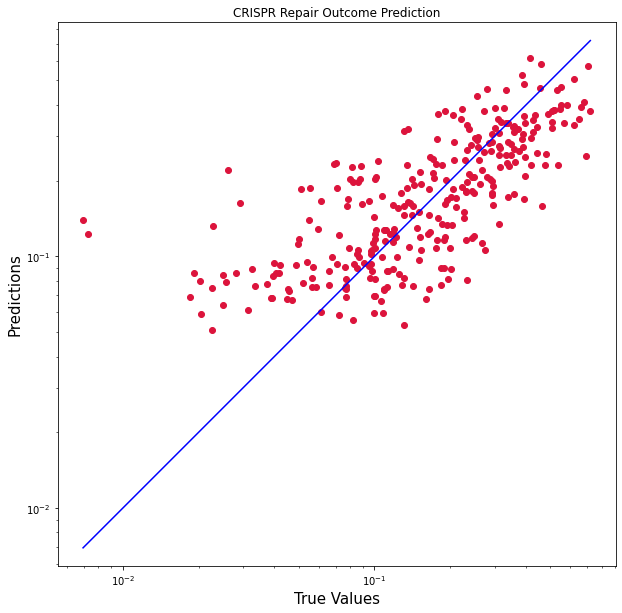

In [33]:
# 최종 테스트 결과 시각화 
import matplotlib.pyplot as plt

# 참값 ~ 예측값 scatter plot 
plt.figure(figsize=(10,10))
plt.scatter(y_label, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_label))
p2 = min(min(y_pred), min(y_label))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('CRISPR Repair Outcome Prediction')
plt.show()

# 수고하셨습니다.